In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
import warnings
warnings.filterwarnings(action='ignore')

In [11]:
# ASOS 관측 데이터
weather = pd.read_csv('../data/기상/OBS_ASOS_DD_20210601231517.csv', encoding = 'cp949')
# ASOS 관측소 메타 데이터
coor = pd.read_csv('../data/기상/META_관측지점정보_20210603224446.csv',encoding='cp949')
# 산사태 발생 이력 데이터
land = pd.read_csv('../data/산사태 발생이력.csv', encoding = 'cp949')
# 행정동 경계 데이터
boundary = gpd.read_file('../data/행정동 경계/umd.shp',encoding='utf-8')

In [14]:
# 경상도에 위치한 ASOS 관측소의 정보만 가져오기 위한 작업
coor['경상도'] = 0
for i in range(len(coor)):
    if coor['지점'].iloc[i] in set(weather['지점']):
        coor['경상도'].iloc[i]=1
        
coor = coor[coor['경상도']==1]

In [10]:
lat = coor['위도'].mean()
long = coor['경도'].mean()

#지도 띄우기
m = folium.Map([lat,long],zoom_start=7)

for i in range(len(coor)):
    #지도에 데이터 찍어서 보여주기
    folium.Marker([coor['위도'].iloc[i],coor['경도'].iloc[i]],tooltip = coor['지점명'].iloc[i]).add_to(m)
m

In [15]:
# 기상청 메타 데이터를 geopandas가 인식할 수 있도록 point 형태로 변환
coor['geometry'] = gpd.points_from_xy(coor.경도,coor.위도)
tmp = gpd.GeoDataFrame({'geometry':coor['geometry']})

# 기상청 페이지에 기재된대로 좌표계 형식 설정 
tmp.crs = {'init':'epsg:4326'}

# 행정동 경계 데이터도 같은 좌표계로 설정해준다.
boundary = boundary.to_crs({'init':'epsg:4326'})

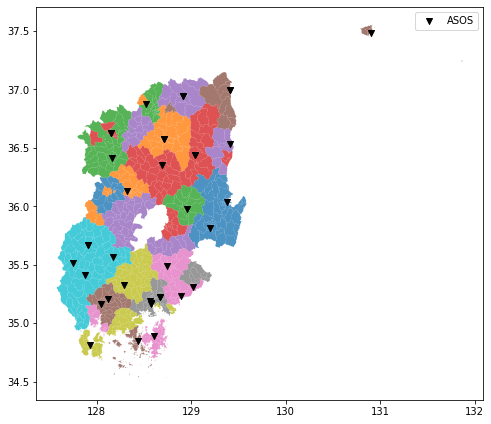

In [16]:
# 행정동 경계 데이터 시각화
ax = boundary.plot(column="ADM_DR_CD", figsize=(8,8), alpha=0.8)
tmp.plot(ax=ax, marker='v', color='black', label='ASOS')
plt.legend()
plt.show()

In [18]:
# 산사태가 발생한 지역의 polygon데이터만 수집
land_bound = pd.DataFrame()
for i in set(land['umd']):
    land_bound = pd.concat([land_bound,boundary[boundary['ADM_DR_NM']==i]],axis=0)
land_bound = land_bound.reset_index().drop('index',axis=1)

In [19]:
# 산사태가 발생한 지역에 속한 ASOS 관측소 찾기
coor['land'] = 0
land_bound['weather'] = 0
for i in range(len(coor)):
    for j in range(len(land_bound)):
        if land_bound['geometry'].iloc[j].contains(coor['geometry'].iloc[i]):
            print(coor['지점명'].iloc[i], land_bound['ADM_DR_NM'].iloc[j])
            coor['land'].iloc[i] = 1
            land_bound['weather'].iloc[j] = 1

울릉도 울릉읍
울진 울진읍
울진 울진읍
통영 정량동
진주 판문동
진주 초장동
북창원 중앙동
창원시 중앙동
의령군 의령읍
함양군 함양읍
영덕 영해면
경주시 선도동
거창 거창읍
거창 거창읍
합천 합천읍
산청 산청읍
남해 이동면


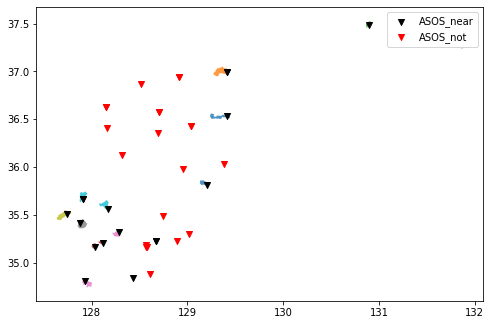

In [21]:
# 산사태 발생 지역에 속한 관측소
near = gpd.GeoDataFrame(coor[coor['land']==1])
# 산사태 발생 지역에 속하지 않은 관측소
not_near = gpd.GeoDataFrame(coor[coor['land']==0])

# ASOS 관측소가 있는 지역만 표현
ax = land_bound[land_bound['weather']==1].plot(column="ADM_DR_CD", figsize=(8,8), alpha=0.8)
near.plot(ax=ax, marker='v', color='black', label='ASOS_near')
not_near.plot(ax=ax, marker='v', color='red', label='ASOS_not')

plt.legend()
plt.show()

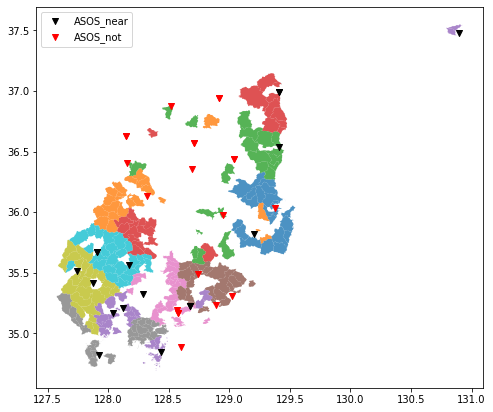

In [22]:
# ASOS 관측소가 없는 지역만 표현

ax = land_bound[land_bound['weather']==0].plot(column="ADM_DR_CD", figsize=(8,8), alpha=0.8)
near.plot(ax=ax, marker='v', color='black', label='ASOS_near')
not_near.plot(ax=ax, marker='v', color='red', label='ASOS_not')

plt.legend()
plt.show()

ASOS 관측소가 행정구역에 모두 속할 줄 알았는데 그렇지 않았다.  
거리를 계산해서 가까운 지역과 관측소 매칭

In [25]:
# 모든 관측소와 거리를 계산하여 가장 가까운 관측소를 매칭
land_bound['ASOS'] = 0
for i in range(len(land_bound)):
    dis = []
    for j in range(len(coor)):
        dis.append(land_bound['geometry'].iloc[i].distance(coor['geometry'].iloc[j]))
    land_bound['ASOS'].iloc[i] = coor['지점명'].iloc[dis.index(min(dis))]

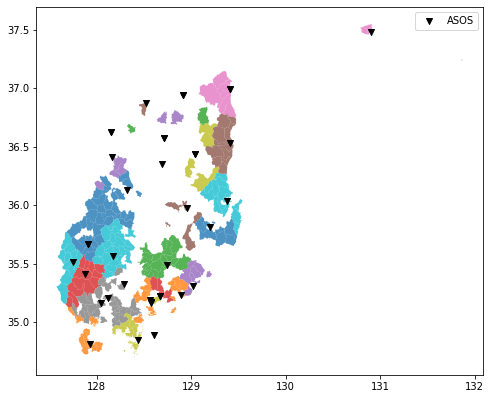

In [26]:
# 행정동 경계 데이터 시각화
ax = land_bound.plot(column="ASOS", figsize=(8,8), alpha=0.8)
tmp.plot(ax=ax, marker='v', color='black', label='ASOS')
plt.legend()
plt.show()

In [27]:
# 하나의 관측소가 커버하는 지역의 개수
for i in set(land_bound['ASOS']):
    print(i,len(land_bound[land_bound['ASOS']==i]))

영덕 12
거창 15
창원 2
영주 1
합천 22
구미 20
상주 5
의령군 4
마산 10
산청 13
경주시 8
안동 2
창원시 1
양산시 7
봉화 1
진주 26
포항 19
청송군 4
김해시 7
밀양 19
영천 7
문경 1
남해 10
통영 12
북창원 7
울진 7
함양군 11
울릉도 3


교체된 관측기에 대한 정보를 정제하고 다시 매칭

In [32]:
coor[coor['지점명']=='창원시']

,지점,시작일,종료일,지점명,지점주소,관리관서,위도,경도,노장해발고도(m),기압계(관측장비지상높이(m)),기온계(관측장비지상높이(m)),풍속계(관측장비지상높이(m)),강우계(관측장비지상높이(m)),geometry,경상도,land
103,255,2008-12-26,2010-07-21,창원시,경상남도 창원시성산구 외동반림로93 외동배수지,NaN,35.2264,128.6725,46.77,48.12,1.8,10.0,0.6,POINT (128.67250 35.22640),1,1


In [33]:
coor[coor['지점명']=='창원']

,지점,시작일,종료일,지점명,지점주소,관리관서,위도,경도,노장해발고도(m),기압계(관측장비지상높이(m)),기온계(관측장비지상높이(m)),풍속계(관측장비지상높이(m)),강우계(관측장비지상높이(m)),geometry,경상도,land
44,155,2010-07-22,NaN,창원,경상남도 창원시마산합포구 가포순환로172 창원기상대,창원기상대(155),35.1702,128.5728,34.97,39.1,1.7,10.0,1.3,POINT (128.57280 35.17020),1,0


In [31]:
land_bound

,BASE_DATE,ADM_DR_CD,ADM_DR_NM,geometry,weather,ASOS
0,20200630,3831032,칠곡면,"POLYGON ((128.21144 35.37417, 128.21097 35.373...",0,의령군
1,20200630,3840036,초계면,"POLYGON ((128.25185 35.57083, 128.25191 35.570...",0,합천
2,20200630,3836039,양보면,"POLYGON ((127.83989 35.10667, 127.84017 35.106...",0,진주
3,20200630,3834040,회화면,"MULTIPOLYGON (((128.41315 35.05485, 128.41314 ...",0,창원
4,20200630,3811411,내서읍,"POLYGON ((128.55776 35.27706, 128.55812 35.277...",0,마산
...,...,...,...,...,...,...
251,20200630,3701131,대송면,"POLYGON ((129.35853 35.98836, 129.35856 35.988...",0,포항
252,20200630,3803070,판문동,"POLYGON ((128.04073 35.21001, 128.04087 35.209...",1,진주
253,20200630,3840035,율곡면,"POLYGON ((128.18524 35.65767, 128.18564 35.657...",0,합천
254,20200630,3838033,유림면,"POLYGON ((127.77931 35.51281, 127.77935 35.512...",0,함양군


In [29]:
weather[weather['지점명']=='창원']

,지점,지점명,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),...,0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm),기사,안개 계속시간(hr)
15350,155,창원,2011-06-09,21.2,18.3,247.0,24.8,1435.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{박무}0230-{박무}{강도0}0300-0430. {연무}0820-{연무}{강도0...,NaN
15351,155,창원,2011-06-10,20.9,18.6,2352.0,23.5,1305.0,9.00,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-{박무}-{박무}{강도0}0300-{박무}{강도0}0600-{박무}{강도0}090...,NaN
15352,155,창원,2011-06-11,21.4,17.3,403.0,26.6,1109.0,2.17,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-{박무}-{박무}{강도0}0300-{박무}{강도0}0600-0820. -{비}-0...,NaN
15353,155,창원,2011-06-12,21.2,18.6,155.0,25.2,1506.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{박무}0420-0540.,NaN
15354,155,창원,2011-06-13,21.4,18.9,532.0,25.3,1349.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{박무}0130-{박무}{강도0}0300-{박무}{강도1}0600-{박무}{강도0}...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18415,155,창원,2019-10-30,13.4,9.3,615.0,19.4,1428.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.5,3.6,NaN,NaN,NaN
18416,155,창원,2019-10-31,14.0,7.7,651.0,21.3,1504.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.5,3.6,NaN,NaN,NaN
18417,155,창원,2019-11-01,15.9,9.5,556.0,22.8,1455.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.8,4.0,NaN,{황사}0610-{황사}{강도0}0900-{황사}{강도0}1200-{황사}{강도0}...,NaN
18418,155,창원,2019-11-02,15.3,10.8,619.0,20.8,1400.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.6,2.3,NaN,{박무}0236-{박무}{강도0}0300-{박무}{강도0}0600-{박무}{강도0}...,NaN


In [30]:
weather[weather['지점명']=='창원시']

,지점,지점명,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),...,0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm),기사,안개 계속시간(hr)
